# Pandas vs. Numpy (matrix dot product) & Word Embeddings

## TOC

* [Preface](#preface)
* [Problem](#problem)
* [Example](#example)
    * [Pandas](#pandas)
    * [Performance](#performance)
* [Bonus](#bonus)
    * [King](#king)

<a id='preface'></a>

## Preface

I'm using [word embeddings](https://en.wikipedia.org/wiki/Word_embedding) to retrieve word similarity in my ([Metaphor](https://metaphor.ml)) project. 

In order to retrieve the `n` most similar words to one specific word embedding I want to compute the cosine similarity between word embeddings:

$$\text{CosineSimilarity(u, v)} = \frac {u . v} {\parallel u \parallel _2 \parallel v \parallel _2} = cos(\theta) $$

If you heard about word embeddings, I'm sure you'll be familiar with this!

<img src="src/word2vec-king-queen-vectors.png">

<center>Queen - Woman + Man = King</center>

<a id='problem'></a>

## Problem

In order to compute all distances to a word $w$ **in one shot** I will need to perform the `dot` product between a matrix of embeddings $E_{nxm}$ and a specific word embedding $w_{mx1}$, where: 

$n$ is the total number of words in my dictionary, **400,000**

$m$ is the number of dimensions of the word embedding (50, 100, 200, 300...)

Because Pandas offers a very nice and easy way of indexing I would prefer to use it, but I don't know if there are gonna be any performance issues in order to perform the `dot` product.

<a id='example'></a>

## Example

### First: all the imports

In [1]:
import pandas as pd
import numpy as np

import csv
import pickle
import cpuinfo
import timeit

# plotting
import seaborn as sns
sns.set_style("darkgrid")
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline

Let's also print the libraries versions so the experiment is contextualized!

In [2]:
print("Pandas: {}\n Numpy: {}".format(pd.__version__,np.__version__))

Pandas: 0.22.0
 Numpy: 1.14.1


Printing also some CPU characteristics:

In [3]:
cpu = cpuinfo.get_cpu_info()
print("Arch: {}\nBrand: {}\nCores: {}".format(cpu['arch'], cpu['brand'], cpu['count']))

Arch: X86_64
Brand: Intel(R) Core(TM) i7-4650U CPU @ 1.70GHz
Cores: 4


<a id='pandas'></a>

### Pandas

The reason I would like to use Pandas is the simplicity to operate with indices. In my matrix of embeddings $E_{nxm}$, the index represent the words from my dictionary and the columns the dimensions of the vectorized words.

In [4]:
np.random.seed(69)
E = pd.DataFrame(np.random.randn(4, 3), index=['house','rocket','science','Trump'])
print(E)

                0         1         2
house    0.915507 -0.603542  1.162295
rocket  -0.601400 -1.597486  0.397726
science  1.205865  1.056299  0.852544
Trump    0.689391 -0.224737 -0.522182


For the sake of the example, because we generated the values randomly, lets make a quick adjustment:

In [5]:
E.loc['rocket'] = E.loc['science'] + (0.1 * np.random.randn(1, ))

A word can be located by its name as an index in the matrix:

In [6]:
word = 'science'
w = E.loc[word]
print(w)

0    1.205865
1    1.056299
2    0.852544
Name: science, dtype: float64


So the distance between vectors can be easily computed:

In [7]:
dot = E.dot(w.transpose())
norm_u = np.linalg.norm(E, axis=1) 
norm_v = np.linalg.norm(w)
cosine_similarity = dot / (norm_u * norm_v)

In [8]:
print(cosine_similarity)

house      0.502312
rocket     0.999928
science    1.000000
Trump      0.091678
dtype: float64


Most similar word?

In [9]:
cosine_similarity.loc[word] = 0 # little trick to avoid retrieving the word
cosine_similarity.nlargest(1)

rocket    0.999928
dtype: float64

<a id='performance'></a>

### Testing performance

Let's encapsulate everything in a function so we can test it multiple times with different data sizes!

In [11]:
def dot_prod_benchmark(n, m, num_iters):
    np.random.seed(69)
    E_np = np.random.randn(n, m)
    w_idx = np.random.randint(n)
    w_np = E_np[w_idx]
    np.random.seed(69)
    E_pd = pd.DataFrame(np.random.randn(n, m))
    w_pd = E_pd.iloc[w_idx]
    
    # numpy
    timeit_np = timeit.Timer('E_np.dot(w_np.T)', globals = locals())
    np_time = timeit_np.timeit(number = num_iters) / num_iters * 1000 

    # pandas    
    timeit_pd = timeit.Timer('E_pd.dot(w_pd.transpose())', globals = locals())
    pd_time = timeit_pd.timeit(number = num_iters) / num_iters * 1000
    
    return np_time, pd_time

In [12]:
np_time, pd_time = dot_prod_benchmark(400000, 50, 1000)
print("Numpy time (ms): {}\nPandas time(ms): {}".format(np_time, pd_time))

Numpy time (ms): 10.18163987697335
Pandas time(ms): 11.321766499022488


We define `full_test` a function that tests the time performance on matrices of incremental size. In this case the default values are:

* `size_jump: 5000`: every iteration on the test we'll increase the matrix number of rows by `5000`
* `max_size: 1000000`: we keep iterating until we reach a final matrix of 1,000,000 rows
* `num_iters: 10`: we repeat the operation 10 times per new matrix (I'd love to repeat it more times but it's computationally expensive.

In [12]:
def full_test(**info):
    saved_file = info.get('saved_file', 'src/data_iter.pickle')
    size_jump = info.get('size_jump', 5000)
    curr_size = info.get('curr_size', size_jump)
    max_size = info.get('max_size', 1000000)
    num_dimensions = info.get('num_dimensions', 50)
    num_iters = info.get('num_iters', 10)
    save_freq = info.get('save_freq', 10)
    sizes_n = range(curr_size, max_size, size_jump)
    sizes_m = [num_dimensions] * len(sizes_n)
    debug = False
    sizes = zip(sizes_n, sizes_m)
    perf_numpy = info.get('perf_numpy', [])
    perf_pandas = info.get('perf_pandas', [])
    for (n, m) in sizes:
        numpy, pandas = dot_prod_benchmark(n, m, num_iters)
        perf_numpy.append(numpy)
        perf_pandas.append(pandas)
        print("Performed on batch of size ({}, {}) with average times: {} ms numpy, {} ms pandas".format(n, m, numpy, pandas))
        if curr_size and curr_size % (save_freq * size_jump) == 0:
            info = {'saved_file': saved_file, 'size_jump': size_jump, 'max_size': max_size, 'num_dimensions': num_dimensions, 
                   'num_iters': num_iters, 'save_freq': save_freq}
            info['perf_numpy'] = perf_numpy
            info['perf_pandas'] = perf_pandas
            info['curr_size'] = curr_size + size_jump
            pickle.dump(info, open(saved_file, "wb" ))
            print("Saving... curr_size = {}".format(info['curr_size']))
        curr_size += size_jump

The call to run the test. Note that every `save_freq` we store our results on a `pickle` file so in case the experiment is interrupted we can continue later from where we left it the last time. 

In [13]:
saved_file = 'src/data_iter.pickle'
try:
    info = pickle.load(open(saved_file, "rb"))
except (OSError, IOError) as e:
    info = {
        'save_freq': 5, 
        'num_iters': 1000,
    }
full_test(**info)

Performed on batch of size (980000, 50) with average times: 23.938734242983628 ms numpy, 26.43098323600134 ms pandas
Performed on batch of size (985000, 50) with average times: 26.61677373800194 ms numpy, 27.272706192015903 ms pandas
Performed on batch of size (990000, 50) with average times: 26.256599735002965 ms numpy, 32.079056367016165 ms pandas
Performed on batch of size (995000, 50) with average times: 29.904807329003233 ms numpy, 30.74835100400378 ms pandas


Awwww, yaaas! I know everyone loves plots!

In [13]:
def my_plot(lim_inf, lim_sup, info):
    size_jump = info.get('size_jump')
    assert lim_inf >= size_jump # test starts at size 'size_jump' (so no smaller values). No need to raise exceptions, message to sel
    assert lim_sup % size_jump == 0 # to create consistent xticks
    assert lim_sup > lim_inf # make it explode!
    lim_sup = min(lim_sup, int(info.get('curr_size')))
    inf = max(0, int(lim_inf / size_jump) - 1)
    sup = int(lim_sup / size_jump)
    t_np = info.get('perf_numpy')[inf:sup]
    t_pd = info.get('perf_pandas')[inf:sup]
    xticks = [*range(lim_inf, lim_sup + size_jump, size_jump)]
    t_np = pd.Series(t_np, index=xticks[:len(t_np)])
    t_pd = pd.Series(t_pd, index=xticks[:len(t_pd)])
    fig, ax = plt.subplots()
    fig.set_size_inches(20,10)
    t_np.plot(label='Numpy', rot=90)
    t_pd.plot(label='Pandas', rot=90)
    plt.ylabel('Time (ms)')
    plt.xlabel('Size')
    plt.legend(loc='best')

In [45]:
saved_file = 'src/data_iter.pickle'
info = pickle.load(open(saved_file, "rb"))

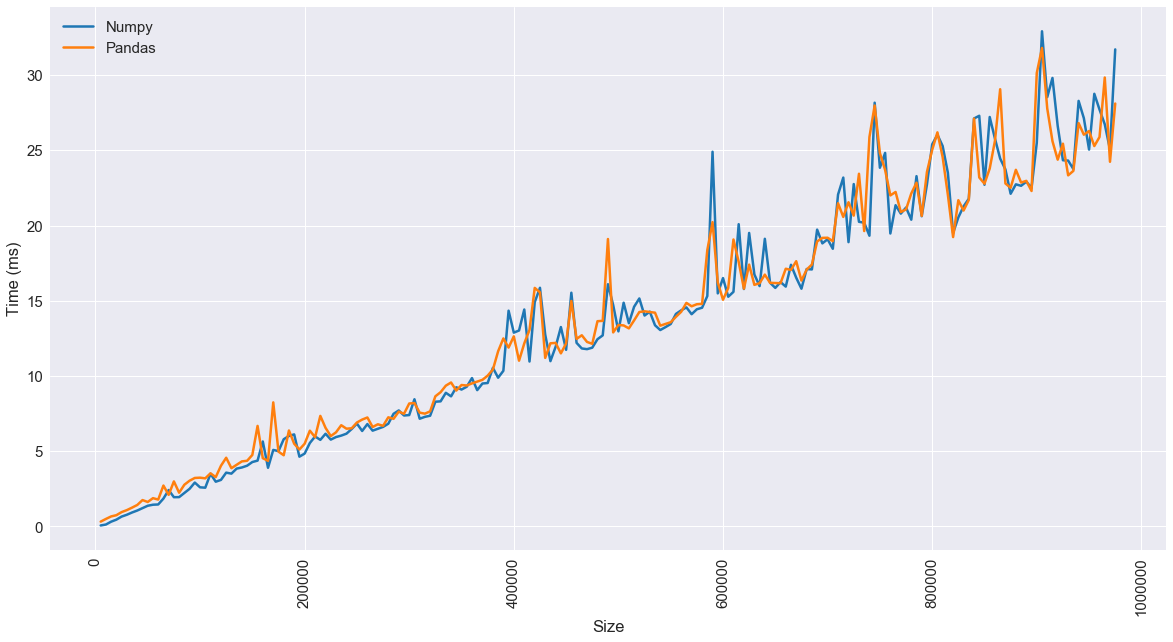

In [47]:
my_plot(5000, 1000000, info)

Given this graph one could say that there is no big difference between Pandas and Numpy in terms of performing the `dot` product operation. Also interesting to note:

* There is a pseudo-lineal growth in time, meaning there is no point where the performance just drops abruptly.
* The last statement is not entirely true given that starting from size 400,000 we observe more "inestability" in times (irregularities)
* It seems to be safe to choose Pandas if the only concern was that it could be less efficient. Actually, lets check the mean times in the next cell!

In [21]:
t_np = info.get('perf_numpy')
t_pd = info.get('perf_pandas')
print("Mean time (ms) numpy: {}\nMean time (ms) pandas: {}".format(np.mean(t_np), np.mean(t_pd)))

Mean time (ms) numpy: 13.640309900584189
Mean time (ms) pandas: 13.764656917930532


There is almost no difference!

Wait, what about zooming in for the first 60,000 sizes?

Text(30500,0.95,'gap 0.32')

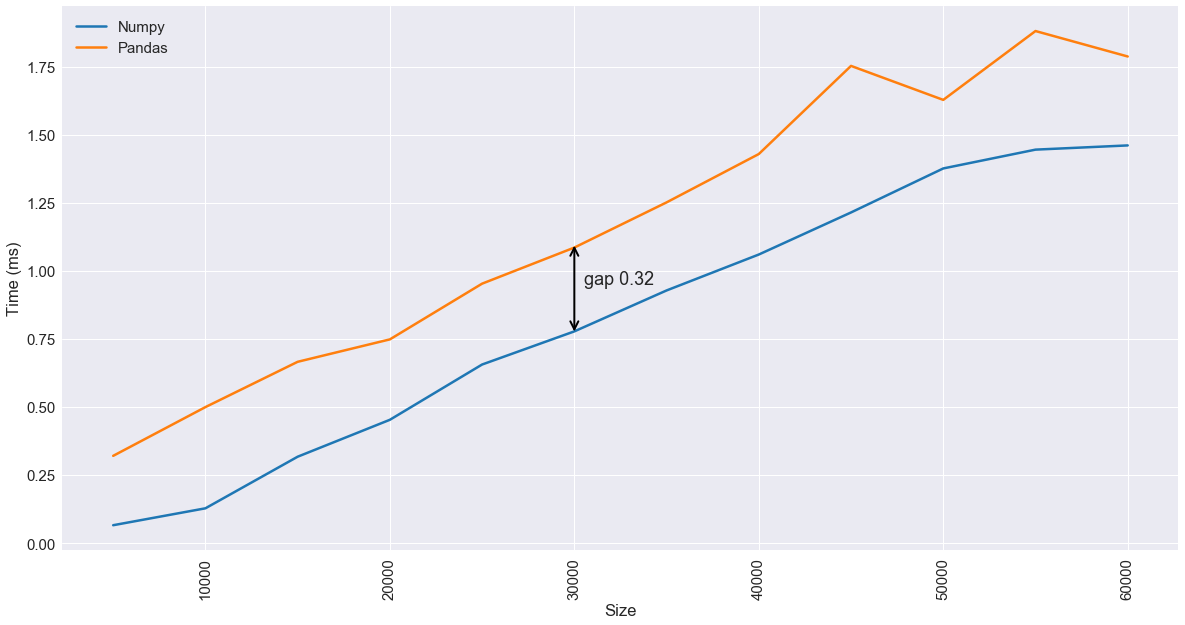

In [229]:
my_plot(5000, 60000, info)
gap = info.get('perf_pandas')[6] - info.get('perf_numpy')[6]
plt.annotate('', (30000, 0.77), xytext=(0, 90), textcoords='offset points', size=20, arrowprops=dict(arrowstyle="<->",lw=2),)
plt.text(30500, 0.95, 'gap {}'.format(round(gap,2)), fontsize=18)

Okay, it looks like there is a "constant" small gap, but only 0.32 ms. Plus, I will be moving in another order of sizes.

Text(0,90,'my size ;-)')

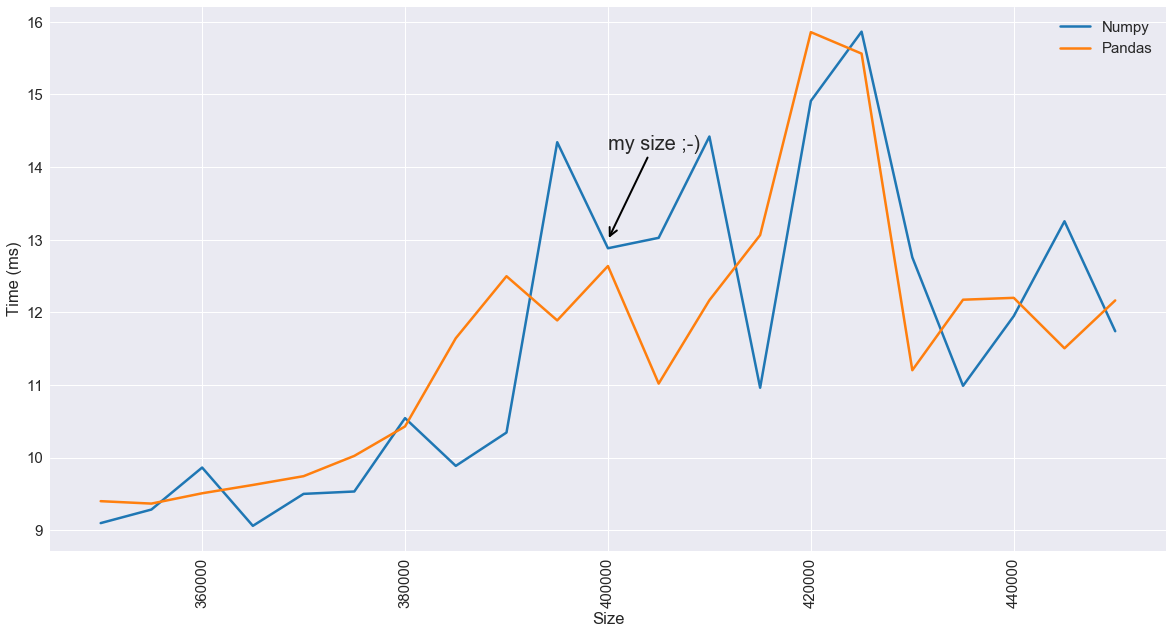

In [234]:
my_plot(350000, 450000, info)
plt.annotate('my size ;-)', (400000, 13), xytext=(0, 90), textcoords='offset points', size=20, arrowprops=dict(arrowstyle="->",lw=2),)

<a id='bonus'></a>

## Bonus

Loading pretrained word embeddings ([GloVe](http://nlp.stanford.edu/data/glove.6B.zip)). 

In [39]:
embeddings_path = 'src/glove.6B.50d.txt'
word_embeddings = pd.read_csv(embeddings_path, sep=" ", index_col=0, header=None, quoting=csv.QUOTE_NONE)

In [17]:
word_embeddings.memory_usage(index=True, deep=True).sum()

186007090

In [18]:
embeddings_size = word_embeddings.memory_usage(index=True, deep=True).sum() / 1024 / 1024
print("Embeddings_size: {} MB".format(round(embeddings_size,2)))

Embeddings_size: 177.39 MB


Given that my server has not much memory, I'd like to optimize the space the embeddings use in my computer. One way would be to sacrifice on values precision, assigning vector values as `np.float16` instead of the default `np.float64`.

In [46]:
embeddings_path = 'src/glove.6B.50d.txt'
dtypes = {k: np.float16 for k in range(1,51)}
word_embeddings = pd.read_csv(embeddings_path, sep=" ", index_col=0, dtype=dtypes, header=None, quoting=csv.QUOTE_NONE)

In [20]:
word_embeddings.memory_usage(index=True, deep=True).sum()

66007090

In [21]:
embeddings_size = word_embeddings.memory_usage(index=True, deep=True).sum() / 1024 / 1024
print("Embeddings_size: {} MB".format(round(embeddings_size,2)))

Embeddings_size: 62.95 MB


In [24]:
print("Wow, a {}x size reduction".format(round(177.39/62.95, 2)))

Wow, a 2.82x size reduction


<a id='king'></a>

### The classic: King - Man + Woman = Queen

Let's encapsulate a function to retrieve the closest `n` words.

In [40]:
def closest_n(word, n=10):
    w = word_embeddings.loc[word]
    dot = word_embeddings.dot(w.transpose())
    norm_u = np.linalg.norm(word_embeddings, axis=1) 
    norm_v = np.linalg.norm(w)
    cosine_similarity = dot / (norm_u * norm_v)
    cosine_similarity.loc[word] = 0 # little trick to avoid retrieving the word
    closest_n = cosine_similarity.nlargest(n)
    return closest_n

In [41]:
queen_example = word_embeddings.loc[['queen', 'woman', 'king', 'man']]
queen_example

,1,2,3,4,5,6,7,8,9,10,...,41,42,43,44,45,46,47,48,49,50
0,,,,,,,,,,,,,,,,,,,,,
queen,0.378540,1.82330,-1.26480,-0.104300,0.35829,0.60029,-0.17538,0.83767,-0.056798,-0.75795,...,0.459460,0.25302,-0.17837,-0.733980,-0.20025,0.23470,-0.56095,-2.28390,0.009275,-0.60284
woman,-0.181530,0.64827,-0.58210,-0.494510,1.54150,1.34500,-0.43305,0.58059,0.355560,-0.25184,...,-0.251740,0.42123,0.48616,0.022325,0.55760,-0.85223,-0.23073,-1.31380,0.487640,-0.10467
king,0.504510,0.68607,-0.59517,-0.022801,0.60046,-0.13498,-0.08813,0.47377,-0.617980,-0.31012,...,0.401020,1.16850,-1.01370,-0.215850,-0.15155,0.78321,-0.91241,-1.61060,-0.644260,-0.51042
man,-0.094386,0.43007,-0.17224,-0.455290,1.64470,0.40335,-0.37263,0.25071,-0.105880,0.10778,...,-0.086264,0.62549,-0.05760,0.293750,0.66005,-0.53115,-0.48233,-0.97925,0.531350,-0.11725


In [42]:
operation = pd.Series(word_embeddings.loc['king'] - word_embeddings.loc['man'] + word_embeddings.loc['woman'], name = 'operation')
queen_example = queen_example.append(operation)

Plotting the words with the magic of t-SNE's dimensionality reduction.

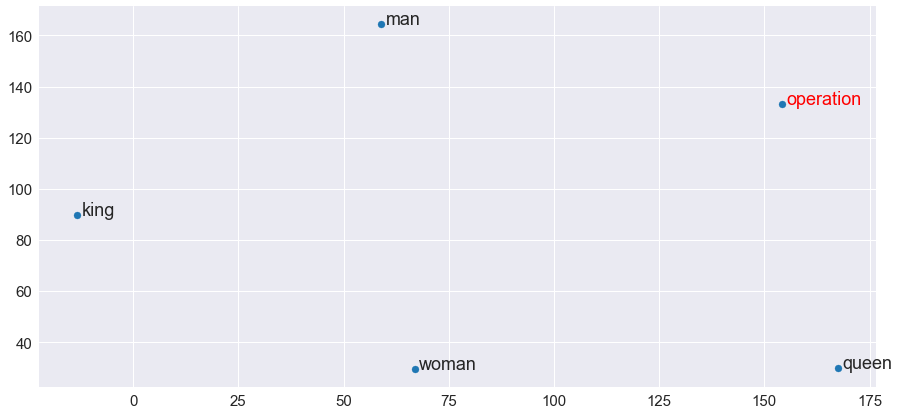

In [43]:
fig, ax = plt.subplots()
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
tsne = TSNE(n_components=2)
Y = tsne.fit_transform(queen_example)
x_coords = Y[:, 0]
y_coords = Y[:, 1]

# display scatter plot
fig.set_size_inches(15,7)
plt.scatter(x_coords, y_coords)

for label, x, y in zip(queen_example.index.values, x_coords, y_coords):
    kwargs = {
        'xy': (x+1, y),
        'xytext': (0, 0),
        'textcoords': 'offset points',
    }
    if label == 'operation':
        kwargs.update({'color': 'red'})
    plt.annotate(label, **kwargs)

plt.show()

We have to take into account that we've "altered" the distances by reducing the vectors into two dimensional dots. But, what if we print the distances using the 50 dimensions of the word embeddings?

Let's define a `complete_analogy` function:

In [47]:
def cosine_similarity(u, v):
    distance = 0.0
    dot = u.dot(v.transpose())
    norm_u = np.sqrt(np.sum(u * u))
    norm_v = np.sqrt(np.sum(v * v))
    cosine_similarity = dot / (norm_u * norm_v)    
    return cosine_similarity

In [62]:
def complete_analogy(word_a, word_b, word_c, word_embeddings):
    e_a, e_b, e_c = word_embeddings.loc[word_a], word_embeddings.loc[word_b], word_embeddings.loc[word_c]
    words = word_embeddings.index.values
    max_cosine_sim = -100              
    best_word = None                   

    # loop over the whole word vector set (in this case I have simplified )
    for w in words:        
        if w in [word_a, word_b, word_c] :
            continue
        cosine_sim = cosine_similarity(e_b - e_a, word_embeddings.loc[w] - e_c)
        if cosine_sim > max_cosine_sim:
            max_cosine_sim = cosine_sim
            best_word = w        
    return best_word

In [63]:
complete_analogy('man', 'king', 'woman', word_embeddings)

queen
